# Project presentation

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import os
import rasterio
import matplotlib.pyplot as plt
from skimage import io
PIL.Image.MAX_IMAGE_PIXELS = 300000000

In [2]:
file="aaa6a05cc.tiff"
file_path=os.path.join("..","..","data","hubmap","train",file)

## Data exploration

In [16]:
src = rasterio.open(file_path)
array = src.read(1)
#array = array.reshape(array.shape[1],array.shape[2],array.shape[0])

/home/nicolasrx/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [53]:
array.shape

(18484, 13013)

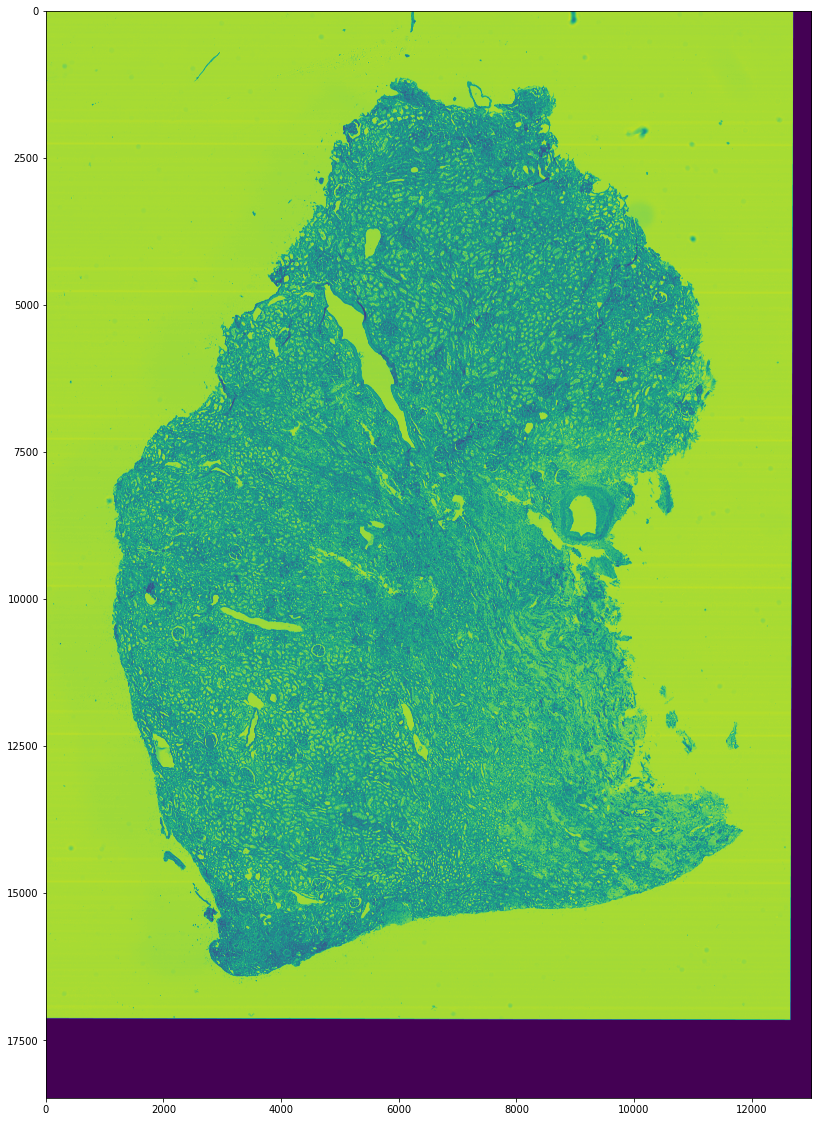

In [9]:
plt.figure(figsize=(30,20))
plt.imshow(array)
plt.show()  

## Data explanation

In [3]:
df=pd.read_csv("../../data/hubmap/train.csv")
print(df)

          id                                           encoding
0  2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
1  aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
2  cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
3  0486052bb  101676003 6 101701785 8 101727568 9 101753351 ...
4  e79de561c  7464094 14 7480273 41 7496453 67 7512632 82 75...
5  095bf7a1f  113430380 22 113468538 67 113506697 111 113544...
6  54f2eec69  124601765 36 124632133 109 124662536 147 12469...
7  1e2425f28  49453112 7 49479881 22 49506657 31 49533433 40...


In [4]:
data_info=pd.read_csv("../../data/hubmap/HuBMAP-20-dataset_information.csv")
#print(data_info[data_info["image_file"]=="aaa6a05cc.tiff"])
example=data_info[data_info["image_file"]=="aaa6a05cc.tiff"]
example=[int(example["height_pixels"]),int(example["width_pixels"])]
print(example)

[18484, 13013]


In [6]:
file_list = [row for row in df["id"]]
file_list

['2f6ecfcdf',
 'aaa6a05cc',
 'cb2d976f4',
 '0486052bb',
 'e79de561c',
 '095bf7a1f',
 '54f2eec69',
 '1e2425f28']

In [5]:
def rle2mask(rle, mask_shape):
    ''' takes a space-delimited RLE string in column-first order
    and turns it into a 2d boolean numpy array of shape mask_shape '''
    
    mask = np.zeros(np.prod(mask_shape), dtype=int) # 1d mask array
    rle = np.array(rle.split()).astype(int) # rle values to ints
    starts = rle[::2]
    lengths = rle[1::2]
    for s, l in zip(starts, lengths):
        mask[s:s+l] = 1
    return mask.reshape(np.flip(mask_shape)).T

In [95]:
mask=rle2mask(df["encoding"][1],example)

In [7]:
import json
json_path="../../data/hubmap/train/aaa6a05cc.json"
annotations = json.load(open(json_path))
#print(type(annotations))
#print(annotations)
annotations = [a["geometry"] for a in annotations]
polygons=[r["coordinates"] for r in annotations]

In [8]:
import cv2
import tifffile as tiff
import matplotlib.pyplot as plt

def create_mask(json_path,image_id, display = True, inv = False):
    annotations = json.load(open(json_path))
    #print(type(annotations))
    #print(annotations)
    annotations = [a["geometry"] for a in annotations]
    polygons=[r["coordinates"][0] for r in annotations]
    
    image = tiff.imread("../../data/hubmap/train/"+image_id)
    dim = image.ndim

    if dim == 5:
        rgb_img = image[0, 0, :, :, :].transpose((1, 2, 0))

    elif dim == 3:
        rgb_img = image

    result_rgb=rgb_img
    
    rgb = result_rgb
    r, g, b = cv2.split(rgb)
    
    if not inv:
        mask= np.zeros((rgb_img.shape[0], rgb_img.shape[1]), dtype = np.uint8)
    else:
        mask= np.ones((rgb_img.shape[0], rgb_img.shape[1]), dtype = np.uint8)
        
    color = 0 if inv else 255
    
    for coordinates in polygons:
        coordinates=np.int32(coordinates)
        #print(np.array(coordinates))
        cv2.fillPoly(mask, pts=[coordinates], color= color)
        
    #mask_resized = cv2.resize(mask, (2000, 2000))
    
    result_r = cv2.bitwise_and(r, r, mask = mask)
    result_g = cv2.bitwise_and(g, g, mask = mask)
    result_b = cv2.bitwise_and(b, b, mask = mask)
    
    result_rgb = cv2.merge((result_r, result_g, result_b))
    

    #result = cv2.resize(result_rgb, (2000, 2000))
    result = result_rgb
    
    if display:
        plt.figure(figsize=(20, 20))
        plt.imshow(result)
        return result
    else:
        return result

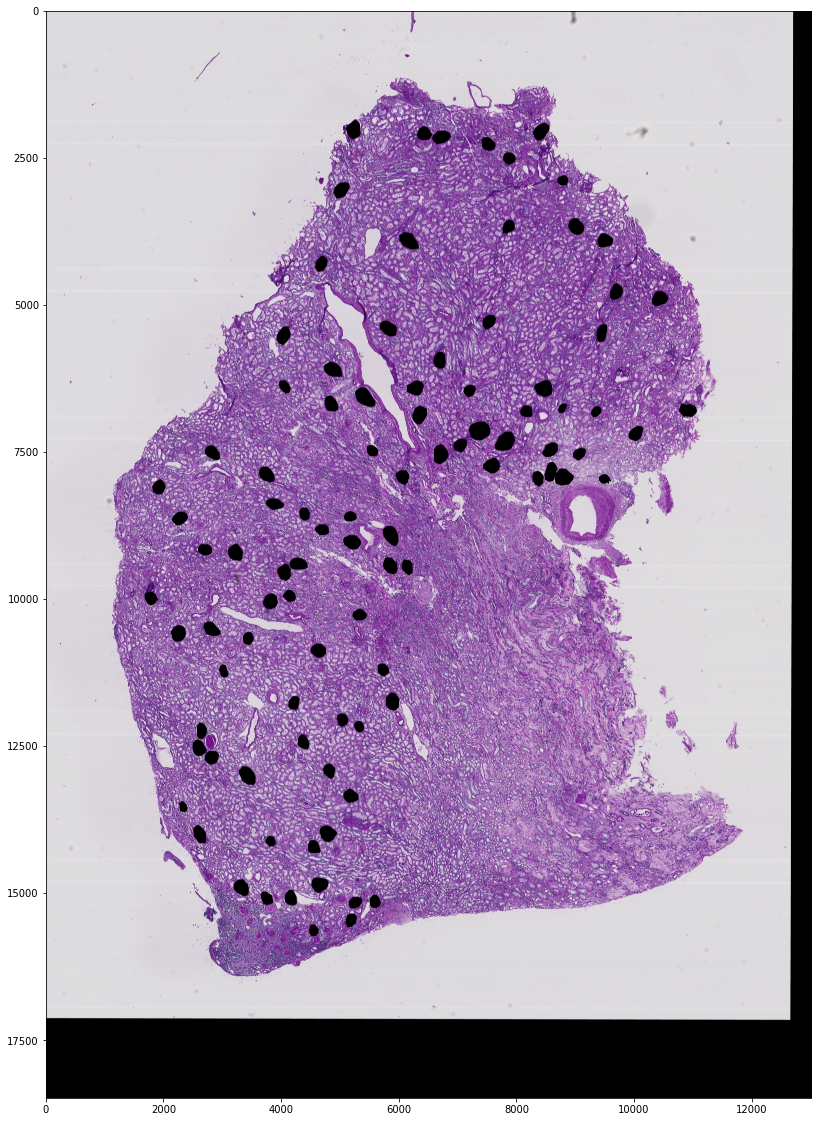

In [9]:
mask=create_mask(json_path,"aaa6a05cc.tiff",inv=True)